# UTS Bagian 2
Farrel Satya Putra Mahendra - 23522009
## CIFAR100 with CNN
Tujuan dari script ini adalah untuk mengklasifikasikan objek dalam dataset CIFAR100 menggunakan metode CNN. Diharapkan hasil akurasi mencapai 40%.

#### Import libraries and modules

In [1]:
import os

import torch
from torch import nn
from torch import optim
from torch import flatten
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

#### Define constants

In [2]:
DATA_DIR = "data"
MODEL_DIR = "models"

EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Create the directory to store the model if not exists
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

#### Import CIFAR100 datasets

Lakukan data augmentation seperti center crop pada gambar dan horizontal flip kemudian dinormalisasi.
Hal ini dilakukan dengan tujuan untuk meningkatkan akurasi tanpa menghilangkan ciri utama dari data tersebut.

In [4]:
# Download training data from open datasets.
training_data = datasets.CIFAR100(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=T.Compose([T.Resize((28,28)),
                         T.RandomHorizontalFlip(), 
                         T.ToTensor(),
                         T.Normalize([0.5071, 0.4867, 0.4408],[0.2675, 0.2565, 0.2761])]),
)

# Download test data from open datasets.
test_data = datasets.CIFAR100(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=T.Compose([T.Resize((28,28)),
                         T.RandomHorizontalFlip(),                  
                         T.ToTensor(),
                         T.Normalize([0.5071, 0.4867, 0.4408],[0.2675, 0.2565, 0.2761])]),
)

Files already downloaded and verified
Files already downloaded and verified


#### Create dataloaders

In [5]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in train_dataloader:
    print("Train --------------------------------------")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
for X, y in test_dataloader:
    print("Test --------------------------------------")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Train --------------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Test --------------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


#### Visualize the data

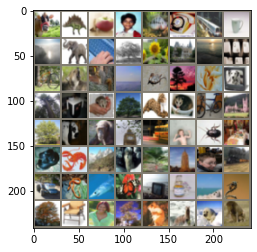

In [18]:
std = [0.2675, 0.2565, 0.2761]
mean = [0.5071, 0.4867, 0.4408]

# See what the data looks like
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

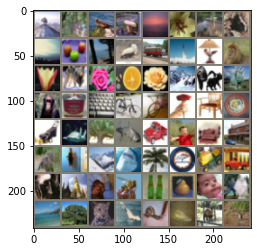

In [19]:
# See what the data looks like
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

#### Define the model using CNN

In [8]:
# Get cpu or gpu device for training
print(f"Using {DEVICE} device")

class CNN(nn.Module):
    def __init__(self, d_out=100):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bn1 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(1024, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        
        self.bn2 = nn.BatchNorm1d(128)
        
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, d_out)
        
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.max_pool1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.max_pool2(out)
        
        out = self.bn1(out)
                
        out = out.reshape(out.size(0), -1)
        # out = torch.flatten(x, 1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        
        out = self.bn2(out)
        
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Define model
model = CNN(d_out=100).to(DEVICE)
print(model)

Using cuda device
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=100, bias=True)
)


#### Define the loss function and optimizer

In [9]:
# To train a model, we need a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training and testing

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f} [{current:>5d}]/{size:>5d}")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    
    return test_loss, correct

In [12]:
# Train and test variables
train_loss_li = [0]
train_acc_li = [0.0]
test_loss_li = [0]
test_acc_li = [0.0]

for t in range(EPOCHS):
    print(f"Epoch {t+1} out of {EPOCHS}\n-------------------------------")
    
    train(train_dataloader, model, loss_fn, optimizer)
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    
    train_loss_li.append(round(train_loss, 8))
    train_acc_li.append(round(train_acc * 100, 2))
    test_loss_li.append(round(test_loss, 8))
    test_acc_li.append(round(test_acc * 100, 2))
    
    print(f"Train Error: \n Accuracy : {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")
    print(f"Test Error: \n Accuracy : {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
print("Done!")

Epoch 1 out of 10
-------------------------------
Loss: 4.652872 [    0]/50000
Loss: 3.994028 [ 6400]/50000
Loss: 3.600060 [12800]/50000
Loss: 3.439097 [19200]/50000
Loss: 3.396606 [25600]/50000
Loss: 3.345561 [32000]/50000
Loss: 3.419840 [38400]/50000
Loss: 3.007762 [44800]/50000
Train Error: 
 Accuracy : 23.9%, Avg loss: 3.108581
Test Error: 
 Accuracy : 22.8%, Avg loss: 3.179449 

Epoch 2 out of 10
-------------------------------
Loss: 3.377820 [    0]/50000
Loss: 3.059242 [ 6400]/50000
Loss: 2.512996 [12800]/50000
Loss: 2.654163 [19200]/50000
Loss: 2.627646 [25600]/50000
Loss: 2.614112 [32000]/50000
Loss: 2.764694 [38400]/50000
Loss: 2.585117 [44800]/50000
Train Error: 
 Accuracy : 35.3%, Avg loss: 2.529579
Test Error: 
 Accuracy : 32.2%, Avg loss: 2.670007 

Epoch 3 out of 10
-------------------------------
Loss: 2.751536 [    0]/50000
Loss: 2.705896 [ 6400]/50000
Loss: 1.981128 [12800]/50000
Loss: 2.321308 [19200]/50000
Loss: 2.315443 [25600]/50000
Loss: 2.501234 [32000]/50000
Lo

#### Result

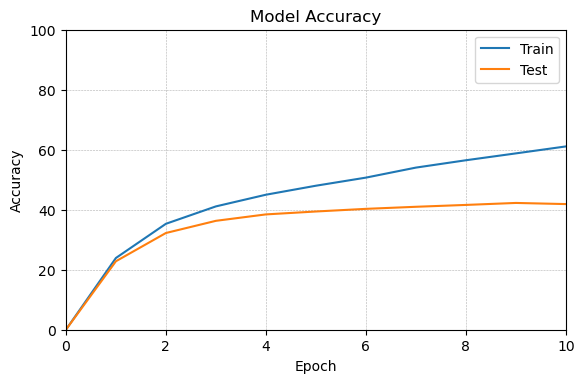

In [20]:
# Show graph
fig = plt.figure(figsize=(5, 3), dpi=100)
axes = fig.add_axes([0,0,1,1])

axes.plot(train_acc_li, label='Train')
axes.plot(test_acc_li, label='Test')
axes.set_title('Model Accuracy')
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy')
axes.set_xlim(0, 10)
axes.set_ylim(0, 100)
axes.grid(visible=True, lw=0.4, ls='dashed')
plt.legend()

plt.savefig('UTS_CIFAR100_CNN.jpg')
plt.show()

In [16]:
print(f"Best training acc: {max(train_acc_li)}%")
print(f"Best testing acc: {max(test_acc_li)}%")

Best training acc: 61.1%
Best testing acc: 42.26%


Hasil akurasi terbaik dari testing mencapai 42,2%. Hal ini bisa terjadi karena menggunakan batch normalization di dalam CNN.